In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('notebook-for-the-final-exam')
jovian.set_colab_id('1zO2ioptsKPG8wRQp2VhPTGii-XowCGh_')

<a id='top'></a>
## Table of Contents
1. [Install and import libraries](#lib)
2. [Prepare the dataset for final exam](#data)
3. [Generate test dataframe](#test)
4. [Pre-processing the test data](#pre-processing)
5. [Predictions and local explanations](#explain)
    1. [Case analysis for regression task](#reg)
    2. [Case analysis for classification task](#cls)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id='lib'></a>
# Install and import libraries ([to top](#top))

In [3]:
!pip3 install shap
!pip3 install dice-ml

In [4]:
import pandas as pd
from pathlib import Path
import numpy as np
from joblib import dump, load
import shap
import warnings
warnings.filterwarnings("ignore")
# Sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.base import TransformerMixin, BaseEstimator
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers.experimental import RandomFourierFeatures
from keras.regularizers import l2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import keras
from numpy.random import seed
seed(1)

# Tensorflow import
import tensorflow as tf
tf.random.set_seed(2)

# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions

%load_ext autoreload
%autoreload 2

# custom transformer for sklearn pipeline
class LabelTransform(TransformerMixin, BaseEstimator):
    def transform(self, X):
      return X

    def fit(self, X, y=None):
      y= np_utils.to_categorical(y)
      return self

def create_model(init='uniform', optimizer='Adam'):
    # define model
    model = Sequential()
    model.add(Dense(64, input_dim=len(train_X.columns), kernel_initializer=init, activation='tanh')) 
    model.add(Dropout(0.2))
    model.add(Dense(100, input_dim=len(train_X.columns))) 
    RandomFourierFeatures(
           output_dim=200, kernel_initializer="gaussian"
       ),
    
    model.add(Dense(2, kernel_initializer=init,kernel_regularizer='l2'))
    model.compile(loss=keras.losses.hinge, optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
  
    return model

np.random.seed(0)

# Fix the probelem that SHAP is not compatible with Pipeline
with open('/usr/local/lib/python3.7/dist-packages/shap/explainers/_permutation.py', 'r') as f:
  filedata = f.read()

# Replace the target string
filedata = filedata.replace('return explanation._old_format()', 'return explanation')

# Write the file out again
with open('/usr/local/lib/python3.7/dist-packages/shap/explainers/_permutation.py', 'w') as file:
  file.write(filedata)

<a id='data'></a>
# Prepare the dataset for final exam ([to top](#top))

In [5]:
if not Path('/content/drive/MyDrive/BDA/input/df_final.csv').is_file():
  # Read column names from file
  cols = list(pd.read_csv('/content/drive/MyDrive/BDA/input/return_df_pre.csv', nrows =1))

  # Use list comprehension to remove the unwanted column in **usecol**
  df = pd.read_csv('/content/drive/MyDrive/BDA/input/return_df_pre.csv', usecols =[i for i in cols if i not in ['revenue', 'return', 'popularity', 'vote_average', 'vote_count']])

  # shift column 'return_log' to last position
  last_column = df.pop('return_log')
  
  # insert column using insert(position, column_name, column) function
  df.insert(len(df.columns), 'return_log', last_column)
  
  # Save the dataframe as a csv file
  df.to_csv('/content/drive/MyDrive/BDA/input/df_final.csv')

else :
  df = pd.read_csv('/content/drive/MyDrive/BDA/input/df_final.csv', index_col=0)

df.head()

,Australia,Canada,China,France,Germany,Hong Kong,India,Italy,Japan,N_spoken_languages,Russia,South Korea,Spain,United Kingdom,United States of America,actor_label_0,actor_label_1,actor_label_2,actor_label_3,belongs_to_collection,budget_tmdb,companies_label_0,companies_label_1,companies_label_2,companies_label_3,director_label_0,director_label_1,director_label_2,is_Action,is_Adventure,is_Animation,is_Biography,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Family,is_Fantasy,is_Foreign,is_Friday,is_History,is_Horror,is_Music,is_Musical,is_Mystery,is_Romance,is_Science Fiction,is_Sport,is_TV Movie,is_Thriller,is_War,is_Western,is_english,month_cos,month_sin,other_country,runtime,writer_label_0,writer_label_1,writer_label_2,writer_label_3,year,return_log
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,1,30000000.0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1.836970e-16,-1.0,0,81.0,0,0,0,1,1995,2.521865
1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,1,0,1,0,65000000.0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,8.660254e-01,-0.5,0,104.0,0,0,1,1,1995,1.396996
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,25000000.0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,8.660254e-01,-0.5,0,101.0,0,0,0,1,1995,1.051080
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,16000000.0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,8.660254e-01,-0.5,0,127.0,0,0,1,0,1995,1.627427
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,30000000.0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,8.660254e-01,0.5,0,106.0,0,0,1,0,1995,0.937124


<a id='test'></a>
# Generate test dataframe ([to top](#top))

In [6]:
# Random select 5 samples.
df.iloc[np.random.choice(len(df), 5)].to_csv('/content/drive/MyDrive/BDA/input/df_test.csv')
df_test = pd.read_csv('/content/drive/MyDrive/BDA/input/df_test.csv', index_col=0)
df_test.head()

,Australia,Canada,China,France,Germany,Hong Kong,India,Italy,Japan,N_spoken_languages,Russia,South Korea,Spain,United Kingdom,United States of America,actor_label_0,actor_label_1,actor_label_2,actor_label_3,belongs_to_collection,budget_tmdb,companies_label_0,companies_label_1,companies_label_2,companies_label_3,director_label_0,director_label_1,director_label_2,is_Action,is_Adventure,is_Animation,is_Biography,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Family,is_Fantasy,is_Foreign,is_Friday,is_History,is_Horror,is_Music,is_Musical,is_Mystery,is_Romance,is_Science Fiction,is_Sport,is_TV Movie,is_Thriller,is_War,is_Western,is_english,month_cos,month_sin,other_country,runtime,writer_label_0,writer_label_1,writer_label_2,writer_label_3,year,return_log
2732,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,1,0,0,1,0,1500000.0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,0.000000,0,98.0,1,0,0,0,2001,-1.280314
3264,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,3000000.0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,-0.500000,-0.866025,0,83.0,1,0,0,0,1985,-6.376931
4859,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,30000000.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.500000,-0.866025,0,126.0,1,0,0,0,2007,1.653999
7891,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,2600000.0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000,0.000000,1,90.0,1,0,0,0,2002,-1.789897
4373,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,558000.0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.866025,-0.500000,0,89.0,0,1,0,0,1931,1.384052


<a id='pre-processing'></a>
# Pre-processing the test dataframe ([to top](#top))

In [7]:
# Load the data
from google.colab import files
src = list(files.upload().values())[0]
open('/content/drive/MyDrive/BDA/input/df_test.csv','wb').write(src)

Saving exam_movies.txt.csv to exam_movies.txt (5).csv


1593

In [8]:
# Add 'profitability' label for classification task
df_test = pd.read_csv('/content/drive/MyDrive/BDA/input/df_test.csv', index_col=0)
df_test['profitability'] = df_test['return_log'].apply(lambda x: 1 if x >=0 else 0)
df_test.head()

,Australia,Canada,China,France,Germany,Hong Kong,India,Italy,Japan,N_spoken_languages,Russia,South Korea,Spain,United Kingdom,United States of America,actor_label_0,actor_label_1,actor_label_2,actor_label_3,belongs_to_collection,budget_tmdb,companies_label_0,companies_label_1,companies_label_2,companies_label_3,director_label_0,director_label_1,director_label_2,is_Action,is_Adventure,is_Animation,is_Biography,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Family,is_Fantasy,is_Foreign,is_Friday,is_History,is_Horror,is_Music,is_Musical,is_Mystery,is_Romance,is_Science Fiction,is_Sport,is_TV Movie,is_Thriller,is_War,is_Western,is_english,month_cos,month_sin,other_country,runtime,writer_label_0,writer_label_1,writer_label_2,writer_label_3,year,return_log,profitability
2021,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1,0,0,1,0,8500000,0,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.500000,-0.866025,0,119,0,0,0,1,2000,0.810951,1
979,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,1,0,0,1344000,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,-0.866025,0.500000,0,134,0,1,0,0,1942,2.307039,1
417,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,55000000,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,-0.866025,-0.500000,0,116,0,0,1,1,1996,-1.082752,0
1362,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,21000000,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0.500000,0.866025,0,104,1,0,1,0,1999,-0.167421,0
8572,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1,0,0,1,0,5000000,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,-0.866025,0.500000,0,120,1,0,0,0,2017,2.353662,1


In [9]:
# Describe the generated test dataframe by some features from the eda dataframe
eda_df = pd.read_csv('/content/drive/MyDrive/BDA/input/eda_df.csv') # we need this dataset to show the features encode with clustering
eda_df.iloc[df_test.index,[11,0,18,6,9,20,1,8]]

,title_tmdb,belongs_to_collection,director_tmdb,production_companies,runtime,year,budget_tmdb,revenue
2021,The Way of the Gun,0,Christopher McQuarrie,['Artisan Entertainment'],119.0,2000,8500000.0,19125401.0
979,Mrs. Miniver,0,William Wyler,['Metro-Goldwyn-Mayer (MGM)'],134.0,1942,1344000.0,13500000.0
417,The Fan,0,Tony Scott,"['TriStar Pictures', 'Mandalay Entertainment']",116.0,1996,55000000.0,18626419.0
1362,The Rage: Carrie 2,1,Katt Shea,"['United Artists', 'Red Bank Films']",104.0,1999,21000000.0,17762705.0
8572,The Big Sick,0,Michael Showalter,"['FilmNation Entertainment', 'Apatow Productio...",120.0,2017,5000000.0,52620184.0


<a id='explain'></a>
# Predictions and local explanations ([to top](#top))

<a id='reg'></a>
## Case analysis for regression task ([to top](#top))

Load the trained Gridient boosting regressor and the features used to train the model.

In [10]:
# Trained Gridient boosting regressor
gbr = load('/content/drive/MyDrive/BDA/models/GradientBoostingRegressor.joblib')
print(gbr)
# The features used to train the model.
gbr_rfe_support = np.load('/content/drive/MyDrive/BDA/models/gbr_rfe_support.npy')
print('\n', [f for f in zip(df_test.columns[:-2] ,gbr_rfe_support)])

GradientBoostingRegressor(learning_rate=0.01, loss='ls', max_depth=6,
                          n_estimators=500, random_state=0, subsample=0.5)

 [('Australia', False), ('Canada', True), ('China', False), ('France', True), ('Germany', True), ('Hong Kong', True), ('India', False), ('Italy', True), ('Japan', False), ('N_spoken_languages', True), ('Russia', False), ('South Korea', False), ('Spain', False), ('United Kingdom', True), ('United States of America', True), ('actor_label_0', True), ('actor_label_1', False), ('actor_label_2', False), ('actor_label_3', True), ('belongs_to_collection', True), ('budget_tmdb', True), ('companies_label_0', True), ('companies_label_1', False), ('companies_label_2', False), ('companies_label_3', True), ('director_label_0', False), ('director_label_1', True), ('director_label_2', True), ('is_Action', True), ('is_Adventure', True), ('is_Animation', True), ('is_Biography', False), ('is_Comedy', True), ('is_Crime', False), ('is_Documentary', False), ('is_D

Get the predictions and put them together with the test dataframe.

In [11]:
X_reg, y_reg = df_test.drop(['return_log', 'profitability'], axis=1).loc[:, gbr_rfe_support], df_test['return_log']
data_reg = X_reg.copy()
data_reg.loc[:,'predict_reg'] = np.round(gbr.predict(data_reg), 2)
data_reg.head()

,Canada,France,Germany,Hong Kong,Italy,N_spoken_languages,United Kingdom,United States of America,actor_label_0,actor_label_3,belongs_to_collection,budget_tmdb,companies_label_0,companies_label_3,director_label_1,director_label_2,is_Action,is_Adventure,is_Animation,is_Comedy,is_Drama,is_Horror,is_Mystery,is_Romance,is_Thriller,is_War,is_Western,is_english,month_cos,month_sin,other_country,runtime,writer_label_2,year,predict_reg
2021,0,0,0,0,0,2,0,1,1,1,0,8500000,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,-0.500000,-0.866025,0,119,0,2000,0.11
979,0,0,0,0,0,2,0,1,0,0,0,1344000,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,1,-0.866025,0.500000,0,134,0,1942,1.25
417,0,0,0,0,0,1,0,1,1,1,0,55000000,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,1,-0.866025,-0.500000,0,116,1,1996,-0.13
1362,0,0,0,0,0,1,0,1,1,0,1,21000000,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0.500000,0.866025,0,104,1,1999,0.23
8572,0,0,0,0,0,2,0,1,1,1,0,5000000,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,-0.866025,0.500000,0,120,0,2017,0.28


Initialize the shap tree explainer

In [12]:
gbr_explainer = shap.TreeExplainer(gbr)
gbr_shap_values = gbr_explainer(data_reg)

Define an index for demonstrating the local explanation

In [13]:
idx_reg = 1

Describe the specified sample by some features from eda data frame.

In [14]:
eda_df.iloc[[data_reg.index[idx_reg]],[11,0,18,6,9,20,1,8]]

,title_tmdb,belongs_to_collection,director_tmdb,production_companies,runtime,year,budget_tmdb,revenue
979,Mrs. Miniver,0,William Wyler,['Metro-Goldwyn-Mayer (MGM)'],134.0,1942,1344000.0,13500000.0


Heatmap plot

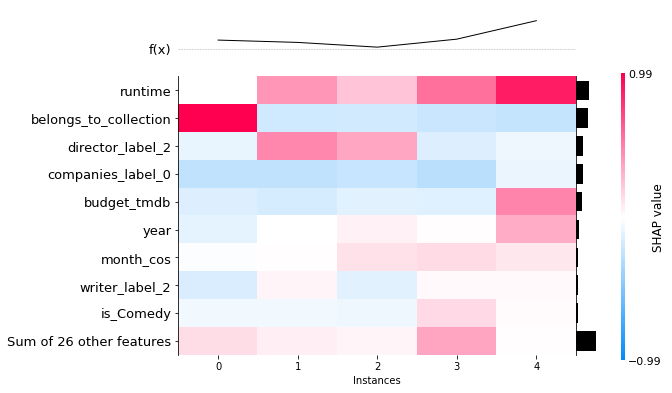

In [15]:
shap.plots.heatmap(gbr_shap_values)

Force plot

In [16]:
shap.initjs()
print("Base value:", y_reg.mean(),
      "\nTarget : ", y_reg.values[idx_reg],
      "\nPrediction : ", data_reg['predict_reg'].values[idx_reg])
shap.force_plot(gbr_explainer.expected_value, gbr_shap_values.values[idx_reg], data_reg.iloc[idx_reg])

Base value: 0.8442957694000001 
Target :  2.3070394430000003 
Prediction :  1.25


Bar plot

Base value: 0.8442957694000001 
Target :  2.3070394430000003 
Prediction :  1.25


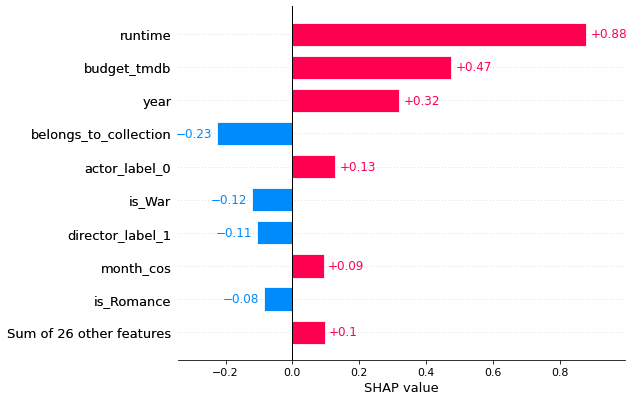

In [17]:
print("Base value:", y_reg.mean(),
      "\nTarget : ", y_reg.values[idx_reg],
      "\nPrediction : ", data_reg['predict_reg'].values[idx_reg])
shap.plots.bar(gbr_shap_values[idx_reg])

Waterfall plot

Base value: 0.8442957694000001 
Target :  2.3070394430000003 
Prediction :  1.25


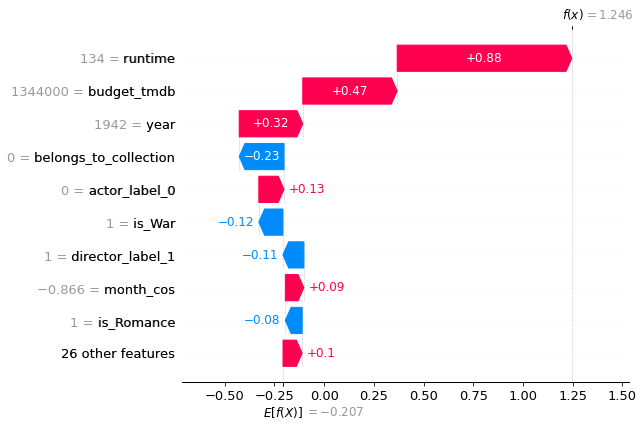

In [18]:
print("Base value:", y_reg.mean(),
      "\nTarget : ", y_reg.values[idx_reg],
      "\nPrediction : ", data_reg['predict_reg'].values[idx_reg])
shap.plots._waterfall.waterfall_legacy(gbr_shap_values.base_values[idx_reg][0], gbr_shap_values.values[idx_reg], features=gbr_shap_values.data[idx_reg], feature_names= X_reg.columns)

Decision plot

Base value: 0.8442957694000001 
Target :  2.3070394430000003 
Prediction :  1.25


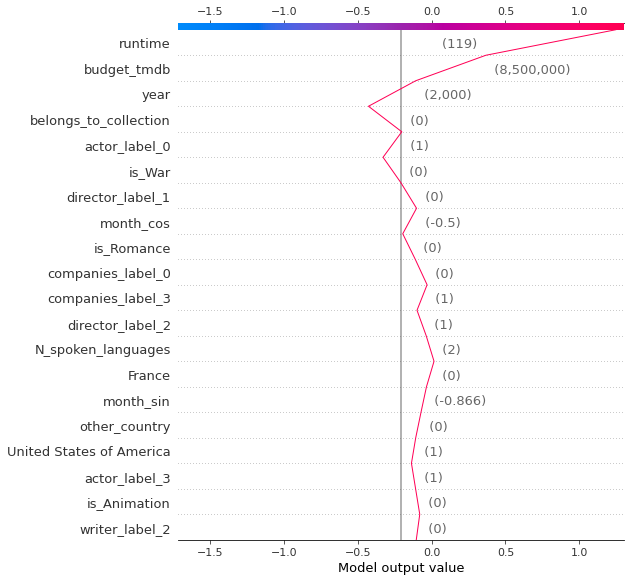

In [19]:
print("Base value:", y_reg.mean(),
      "\nTarget : ", y_reg.values[idx_reg],
      "\nPrediction : ", data_reg['predict_reg'].values[idx_reg])
shap.decision_plot(gbr_explainer.expected_value, gbr_shap_values.values[idx_reg], data_reg)

<a id='cls'></a>
## Case analysis for classification task ([to top](#top))

Load the trained stacking classifier.

In [20]:
stc = load('/content/drive/MyDrive/BDA/models/StackingClassifierPipeline.joblib')
print(stc)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 StackingClassifier(estimators=[('RandomForest',
                                                 RandomForestClassifier(criterion='entropy',
                                                                        min_samples_leaf=2,
                                                                        min_samples_split=9,
                                                                        n_estimators=700,
                                                                        random_state=0)),
                                                ('GradientBossting',
                                                 GradientBoostingClassifier(learning_rate=0.01,
                                                                            max_depth=10,
                                                                            n_estimators=500,
                                                     

Get the predictions and put them together with the test dataframe.

In [21]:
X_cls, y_cls = df_test.drop(['return_log', 'profitability'], axis=1), df_test['profitability']
data_cls = X_cls.copy()
data_cls.loc[:,'predict_cls'] = stc.predict(data_cls)
data_cls.head()

,Australia,Canada,China,France,Germany,Hong Kong,India,Italy,Japan,N_spoken_languages,Russia,South Korea,Spain,United Kingdom,United States of America,actor_label_0,actor_label_1,actor_label_2,actor_label_3,belongs_to_collection,budget_tmdb,companies_label_0,companies_label_1,companies_label_2,companies_label_3,director_label_0,director_label_1,director_label_2,is_Action,is_Adventure,is_Animation,is_Biography,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Family,is_Fantasy,is_Foreign,is_Friday,is_History,is_Horror,is_Music,is_Musical,is_Mystery,is_Romance,is_Science Fiction,is_Sport,is_TV Movie,is_Thriller,is_War,is_Western,is_english,month_cos,month_sin,other_country,runtime,writer_label_0,writer_label_1,writer_label_2,writer_label_3,year,predict_cls
2021,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1,0,0,1,0,8500000,0,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.500000,-0.866025,0,119,0,0,0,1,2000,1
979,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,1,0,0,1344000,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,-0.866025,0.500000,0,134,0,1,0,0,1942,1
417,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,55000000,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,-0.866025,-0.500000,0,116,0,0,1,1,1996,0
1362,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,21000000,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0.500000,0.866025,0,104,1,0,1,0,1999,0
8572,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1,0,0,1,0,5000000,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,-0.866025,0.500000,0,120,1,0,0,0,2017,1


Initialize the shap permutation explainer

In [22]:
stc_explainer = shap.Explainer(stc.predict, X_cls)
stc_shap_values = stc_explainer.shap_values(X_cls)

Permutation explainer: 6it [00:13,  6.58s/it]


Define an index for demonstrating the local explanation

In [23]:
idx_cls = 2

Describe the specified sample by some features from eda data frame.

In [24]:
eda_df.iloc[[data_reg.index[idx_cls]],[11,0,18,6,9,20,1,8]]

,title_tmdb,belongs_to_collection,director_tmdb,production_companies,runtime,year,budget_tmdb,revenue
417,The Fan,0,Tony Scott,"['TriStar Pictures', 'Mandalay Entertainment']",116.0,1996,55000000.0,18626419.0


Heatmap plot

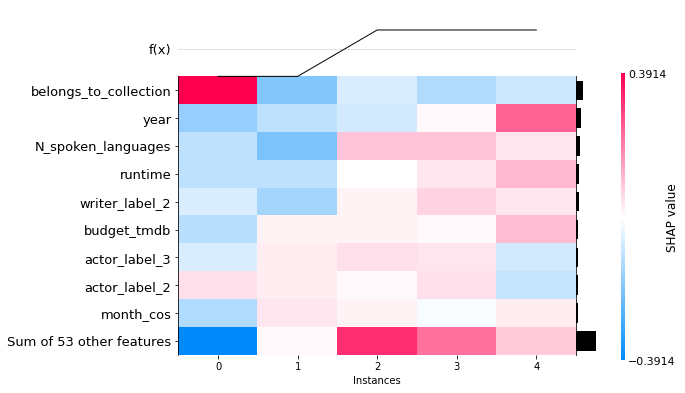

In [25]:
shap.plots.heatmap(stc_shap_values)

Force plot

In [26]:
shap.initjs()
print("Base value:", y_cls.mean(),
      "\nTarget : ", y_cls.values[idx_cls],
      "\nPrediction : ", data_cls['predict_cls'].values[idx_cls])
shap.force_plot(stc_shap_values.base_values[idx_cls], stc_shap_values.values[idx_cls], X_cls.iloc[idx_cls])

Base value: 0.6 
Target :  0 
Prediction :  0


Bar plot

Base value: 0.6 
Target :  0 
Prediction :  0


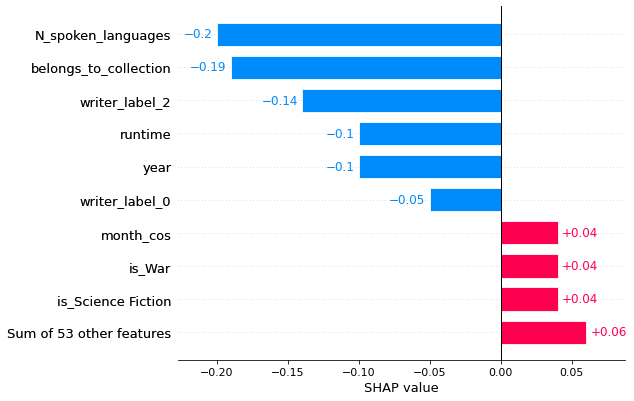

In [27]:
print("Base value:", y_cls.mean(),
      "\nTarget : ", y_cls.values[idx_cls],
      "\nPrediction : ", data_cls['predict_cls'].values[idx_cls])
shap.plots.bar(stc_shap_values[idx_cls])

Waterfall plot

Base value: 0.6 
Target :  0 
Prediction :  0


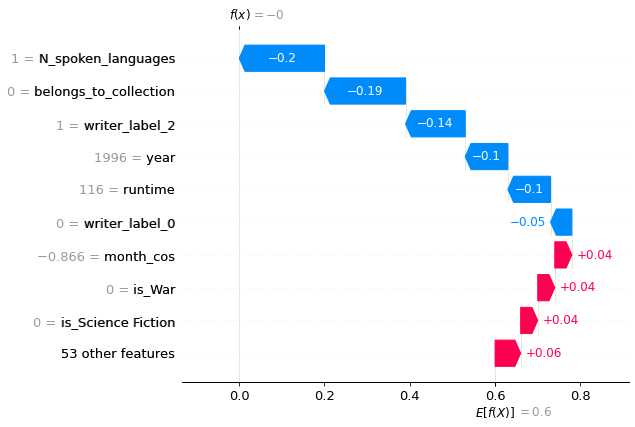

In [28]:
print("Base value:", y_cls.mean(),
      "\nTarget : ", y_cls.values[idx_cls],
      "\nPrediction : ", data_cls['predict_cls'].values[idx_cls])
shap.plots._waterfall.waterfall_legacy(stc_shap_values.base_values[idx_cls], stc_shap_values.values[idx_cls], features=stc_shap_values.data[idx_cls], feature_names= X_cls.columns)

Decision plot

Base value: 0.6 
Target :  0 
Prediction :  0


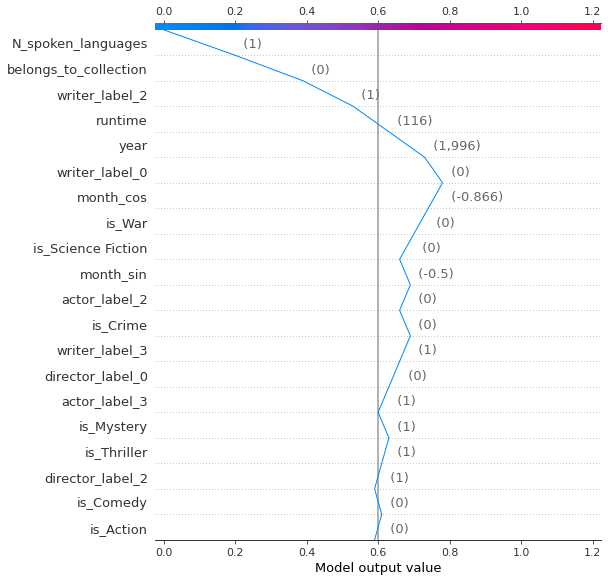

In [29]:
print("Base value:", y_cls.mean(),
      "\nTarget : ", y_cls.values[idx_cls],
      "\nPrediction : ", data_cls['predict_cls'].values[idx_cls])
shap.decision_plot(stc_shap_values.base_values[idx_cls], stc_shap_values.values[idx_cls], X_cls.iloc[idx_cls])

Initialize the DiCE (Diverse Counterfactual Explanations)

In [30]:
# Pre-defined Data frame
d = dice_ml.Data(dataframe=data_cls, continuous_features= ['budget_tmdb', 'N_spoken_languages', 'month_sin', 'month_cos', 'runtime','year'], outcome_name='predict_cls')
# Pre-trained ML model
m = dice_ml.Model(model=stc, backend='sklearn')
# DiCE explanation instance
exp = dice_ml.Dice(d, m, method="random")

Generate the Diverse Counterfactual set for the specified sample

In [31]:
dice_exp = exp.generate_counterfactuals(data_cls.iloc[[idx_cls]].iloc[:, :-1],
                                        total_CFs=5, 
                                        desired_class="opposite", 
                                        random_seed=42, 
                                        verbose=False,
                                        features_to_vary = data_cls.iloc[:,:-1][data_cls.iloc[:,:-1].columns.difference(['year', 'month_sin', 'month_cos'])].columns.to_list())
dice_exp.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:02<00:00,  2.47s/it]

Query instance (original outcome : 0)


,Australia,Canada,China,France,Germany,Hong Kong,India,Italy,Japan,N_spoken_languages,Russia,South Korea,Spain,United Kingdom,United States of America,actor_label_0,actor_label_1,actor_label_2,actor_label_3,belongs_to_collection,budget_tmdb,companies_label_0,companies_label_1,companies_label_2,companies_label_3,director_label_0,director_label_1,director_label_2,is_Action,is_Adventure,is_Animation,is_Biography,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Family,is_Fantasy,is_Foreign,is_Friday,is_History,is_Horror,is_Music,is_Musical,is_Mystery,is_Romance,is_Science Fiction,is_Sport,is_TV Movie,is_Thriller,is_War,is_Western,is_english,month_cos,month_sin,other_country,runtime,writer_label_0,writer_label_1,writer_label_2,writer_label_3,year,predict_cls
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,55000000,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,-0.866025,-0.5,0,116,0,0,1,1,1996,0



Diverse Counterfactual set (new outcome: 1.0)


,Australia,Canada,China,France,Germany,Hong Kong,India,Italy,Japan,N_spoken_languages,Russia,South Korea,Spain,United Kingdom,United States of America,actor_label_0,actor_label_1,actor_label_2,actor_label_3,belongs_to_collection,budget_tmdb,companies_label_0,companies_label_1,companies_label_2,companies_label_3,director_label_0,director_label_1,director_label_2,is_Action,is_Adventure,is_Animation,is_Biography,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Family,is_Fantasy,is_Foreign,is_Friday,is_History,is_Horror,is_Music,is_Musical,is_Mystery,is_Romance,is_Science Fiction,is_Sport,is_TV Movie,is_Thriller,is_War,is_Western,is_english,month_cos,month_sin,other_country,runtime,writer_label_0,writer_label_1,writer_label_2,writer_label_3,year,predict_cls
0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,131.0,-,-,-,-,-,1.0
1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0,-,1.0
2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,16184260.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0
3,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0
4,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,134.0,-,-,-,-,-,1.0


# Save the notebook ([to top](#top))

In [32]:
!pip install jovian --upgrade --quiet
import jovian
# Execute this to save new versions of the notebook
jovian.commit(project="notebook-for-the-final-exam")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/lilanpei/notebook-for-the-final-exam


'https://jovian.ai/lilanpei/notebook-for-the-final-exam'